<a href="https://colab.research.google.com/github/MarshaGomez/CNN-Medical-Imaging-Analysis/blob/main/Code/Knowing_DDSM_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True) 

Mounted at /content/gdrive


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import seaborn as sns
import pandas as pd 
import os 


BATCH_SIZE = 20
EPOCHS = 100

base_path = "/content/gdrive/My Drive/Colab_Notebooks/CIDL/DL Project"

MODEL_PATH = os.path.join(base_path, "models")
PLOTS_PATH = os.path.join(base_path, "plots/Masses-Calcifications")
RESULT_PATH = os.path.join(base_path, "results/Masses-Calcifications")

train_img_path = os.path.join(base_path, "numpy data/train_tensor.npy")
train_label_path = os.path.join(base_path, "numpy data/train_labels.npy")
test_img_path = os.path.join(base_path, "numpy data/public_test_tensor.npy")
test_label_path = os.path.join(base_path, "numpy data/public_test_labels.npy")


file_path = os.path.join(RESULT_PATH, "results-CM.csv")

print("Done")

Done


In [ ]:
# Load Arrays from Numpy Files
def load_training():
  train_images = np.load(train_img_path)
  train_labels = np.load(train_label_path)
  test_images = np.load(test_img_path)
  test_labels = np.load(test_label_path)

  return train_images, train_labels, test_images, test_labels

# Remove baseline samples
def remove_baseline(tensor): 
  max_ind = int(len(tensor)/2)
  indexes = [2*i + 1 for i in range(0, max_ind)]

  return tensor[indexes]

# Interchange the dataset index
def shuffle_dataset(x, y):
  indices = tf.range(start=0, limit=tf.shape(x)[0], dtype=tf.int32)
  shuffled_indices = tf.random.shuffle(indices)

  x = tf.gather(x, shuffled_indices)
  y = tf.gather(y, shuffled_indices)

  x = x.numpy()
  y = y.numpy()

  return x, y

# Unify masses and calcifications 
def labels_mapping(labels):
  labels_local = np.zeros(shape=labels.shape, dtype="float32")
  idx = 0
  for label in labels:
    # Masses
    if label == 1 or label == 2:
      labels_local[idx] = 0
    # Calcifications
    else:
      labels_local[idx] = 1
    idx += 1

  return labels_local

# Unify masses bening and malign
def labels_masses(labels):
  labels_local = np.zeros(shape=labels.shape, dtype="int")
  idx = 0
  for label in labels:
    # Masses
    if label ==1:
      labels_local[idx] = 0
    elif label == 2:
      labels_local[idx] = 1
    idx += 1

  return labels_local


# Unify masses bening and malign
def labels_calc(labels):
  labels_local = np.zeros(shape=labels.shape, dtype="int")
  idx = 0
  for label in labels:
    # Masses
    if label ==3:
      labels_local[idx] = 0
    elif label == 4:
      labels_local[idx] = 1
    idx += 1

  return labels_local

print("Done")

Done


In [ ]:
# Visualization Confusion Matrix
def plot_confusion_matrix(classes, # Array with the classes name
                          datagen,
                          dataset, 
                          labels,
                          batch_size=BATCH_SIZE,
                          title='Confusion matrix'):
    """
    This function prints and plots the confusion matrix.
    """
    predicted = model.predict(datagen.flow(dataset,
                                            labels,
                                            batch_size=batch_size,
                                            shuffle=False),
                          steps=len(dataset) // batch_size)

    prediction = np.where(predicted < 0.5, 0, 1)

    print('Confusion Matrix')
    cm = confusion_matrix(labels, prediction)

    print(classification_report(labels, prediction))

    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Visualization Data Histogram
def plot(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  return plt

# Visualization Detail Metric
def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  plt.figure(figsize=(12,10))

  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)

    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

  return plt

def plot_bar(train_labels, test_labels, title):
  # Train Values
  (unique, counts) = np.unique(train_labels, return_counts=True)
  counts = percentages(counts)
  bars1 = counts

  # Test Values
  (unique, counts) = np.unique(test_labels, return_counts=True)
  counts = percentages(counts)
  bars2 = counts

  # set width of bar
  barWidth = 0.40
  
  # set height of bar
  
  # Set position of bar on X axis
  r1 = np.arange(len(bars1))
  r2 = [x + barWidth for x in r1]

  # Make the plot
  plt.bar(r1, bars1, width=barWidth, edgecolor='white', label='Train set')
  plt.bar(r2, bars2, width=barWidth, edgecolor='white', label='Test set')
  
  # Add xticks on the middle of the group bars
  plt.xlabel('Class', fontweight='bold')
  plt.xticks([r + barWidth for r in range(len(bars1))], unique)
  plt.ylabel('Percentages quantity', fontweight='bold')

  
  # Create legend & Show graphic
  plt.legend()
  plt.title(title)

  return plt


def plot_AUC(model, dataset, labels):
  y_pred_keras = model.predict(dataset).ravel()
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(labels, y_pred_keras)
  auc_keras = auc(fpr_keras, tpr_keras)

  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr_keras, tpr_keras, label='CNN (area = {:.3f})'.format(auc_keras))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')

  return plt

print("Done")

Done


## Load Data

In [ ]:
# Get images and labels (test, train)
train_images, train_labels, test_images, test_labels = load_training()

print("Done")

Done


In [ ]:
print(type(train_images[0]))

<class 'numpy.ndarray'>


## Exploring the Dataset

### Data Distribution by Class

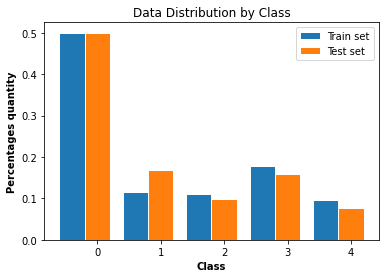

In [ ]:
def percentages(a):
    return a / np.sum(a)

# Train Values
(unique, counts) = np.unique(train_labels, return_counts=True)
counts = percentages(counts)
bars1 = counts

# Test Values
(unique, counts) = np.unique(test_labels, return_counts=True)
counts = percentages(counts)
bars2 = counts

# set width of bar
barWidth = 0.40
 
# set height of bar
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

# Make the plot
plt.bar(r1, bars1, width=barWidth, edgecolor='white', label='Train set')
plt.bar(r2, bars2, width=barWidth, edgecolor='white', label='Test set')
 
# Add xticks on the middle of the group bars
plt.xlabel('Class', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], unique)
plt.ylabel('Percentages quantity', fontweight='bold')

 
# Create legend & Show graphic
plt.legend()
plt.title('Data Distribution by Class')


plt.savefig(os.path.join(PLOTS_PATH, "intro-dataset-class.png"))
plt.show()

[ 0  5 10 15 20 25 30 35]
[1.3, 6.3, 11.3, 16.3, 21.3, 26.3, 31.3, 36.3]


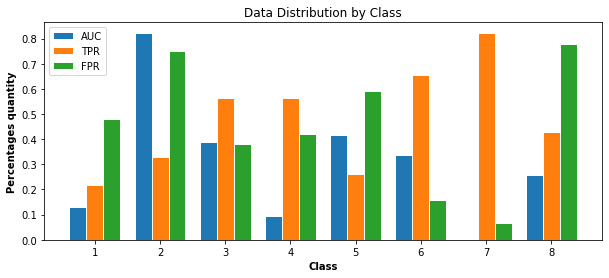

In [ ]:
AUC_values = np.random.rand(8)
TPR_values = np.random.rand(8)
FPR_values = np.random.rand(8)
PRECISION_values = np.random.rand(8)
SPECIFICITY_values = np.random.rand(8)

x_labels = ["1", "2", "3", "4", "5", "6", "7", "8"]

# AUC values
counts = AUC_values
bars1 = counts

# TPR values
counts = TPR_values
bars2 = counts

#FPR values
counts = FPR_values
bars3 = counts

# set width of bar
barWidth = 1.3
 
# set height of bar
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))*5
print(r1)
r2 = [x + barWidth for x in r1]
print(r2)
r3 = [x + barWidth for x in r2]
#print(r3)


fig= plt.figure(figsize=(10,4))

# Make the plot
plt.bar(r1, bars1, width=barWidth, edgecolor='white', label='AUC')
plt.bar(r2, bars2, width=barWidth, edgecolor='white', label='TPR')
plt.bar(r3, bars3, width=barWidth, edgecolor='white', label='FPR')
 
# Add xticks on the middle of the group bars
plt.xlabel('Class', fontweight='bold')
plt.xticks([r + barWidth for r in r1], x_labels)
plt.ylabel('Percentages quantity', fontweight='bold')

 
# Create legend & Show graphic
plt.legend()
plt.title('Data Distribution by Class')

#plt.savefig(os.path.join(PLOTS_PATH, "intro-dataset-class.png"))
plt.show()

In [ ]:
# Get abnormalities only 
train_images = remove_baseline(train_images)
train_labels = remove_baseline(train_labels)
test_images = remove_baseline(test_images)
test_labels = remove_baseline(test_labels)

print("Done")

### Masses and Calcification

In [ ]:
# Mapping labels with standard index
train_labels_mapping = labels_mapping(train_labels)
test_labels_mapping = labels_mapping(test_labels)

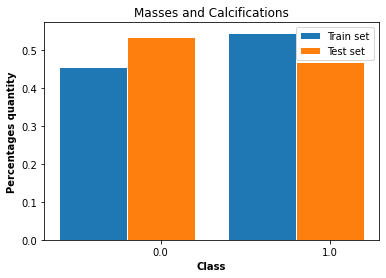

In [ ]:
title = 'Masses and Calcifications'
plt = plot_bar(train_labels_mapping, test_labels_mapping, title)
plt.savefig(os.path.join(PLOTS_PATH, "intro-dataset-calc-mass.png"))
plt.show()

### Calcification Casses

In [ ]:
# Mapping labels with standard index
train_labels_calc = labels_calc(train_labels)
test_labels_calc = labels_calc(test_labels)

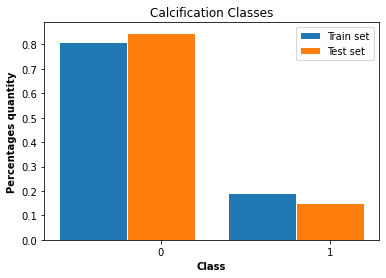

In [ ]:
title = 'Calcification Classes'
plt = plot_bar(train_labels_calc, test_labels_calc, title)
plt.savefig(os.path.join(PLOTS_PATH, "intro-dataset-calc.png"))
plt.show()

In [ ]:
# Save Images Example Calcifications and Masses
plt.imsave(os.path.join(PLOTS_PATH, "intro-masses-malign.png"), train_images[1], cmap='Greys_r')
plt.imsave(os.path.join(PLOTS_PATH, "intro-calc-malign.png"), train_images[2674], cmap='Greys_r')
plt.imsave(os.path.join(PLOTS_PATH, "intro-masses-benign.png"), train_images[2], cmap='Greys_r')
plt.imsave(os.path.join(PLOTS_PATH, "intro-calc-benign.png"), train_images[2675], cmap='Greys_r')

print("Done")

Done


### Masses Casses

In [ ]:
# Mapping labels with standard index
train_labels_masses = labels_masses(train_labels)
test_labels_masses = labels_masses(test_labels)

print("Done")

Done


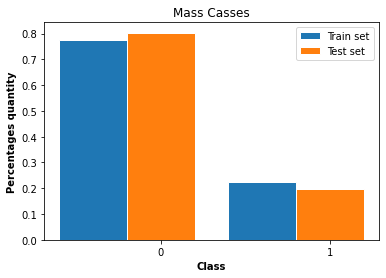

In [ ]:
title = 'Mass Casses'
plt = plot_bar(train_labels_masses, test_labels_masses, title)
plt.savefig(os.path.join(PLOTS_PATH, "intro-dataset-masses.png"))
plt.show()

###Plot the results of all models Masses-Calcifications


In [ ]:
data = pd.read_csv(file_path)
data.sort_values(by=['mean_val_acc'], ascending=False, inplace=True)
data.head()

,name,batch_size,num_epochs,units_per_layer,optimizer,learning_rate,mean_val_acc,std,mean_val_loss,std_loss,num_folds
17,Model_18,20,100,[32 64 128 256],RMSprop,0.01,0.8865,(+/- 0.0199),0.3096,(+/- 0.0342),5
16,Model_17,20,100,[32 64 128 128],RMSprop,0.01,0.8865,(+/- 0.0318),0.3032,(+/- 0.0726),5
7,Model_8,32,100,[32 64 128 256],Adam,0.01,0.8859,(+/- 0.0338),0.3226,(+/- 0.0636),5
34,Model_35,20,100,[32 64 128 128],Adam,0.01,0.8815,(+/- 0.0416),0.3031,(+/- 0.0700),5
18,Model_19,20,100,[32 64 128 128],Adam,0.01,0.8808,(+/- 0.0297),0.3143,(+/- 0.0516),5


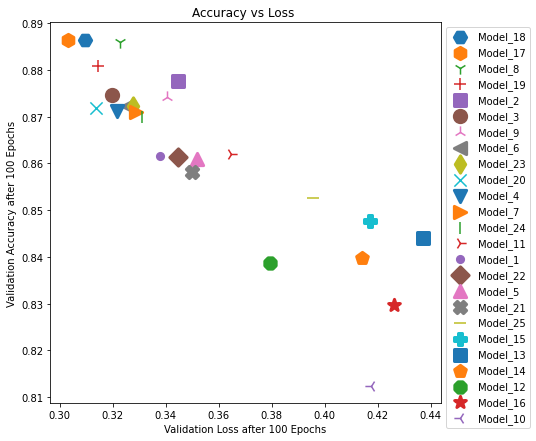

In [ ]:
markers=[".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_"]

plt.figure(figsize=(7,7))
for row in data.itertuples():
  if row.Index <= 24:
    plt.scatter(row.mean_val_loss, row.mean_val_acc, label=row.name, marker=markers[row.Index], s=150, linewidths=3)
    

plt.xlabel('Validation Loss after 100 Epochs')
plt.ylabel('Validation Accuracy after 100 Epochs')
plt.title('Accuracy vs Loss ')

# Move legend out of the plot
plt.legend(bbox_to_anchor=(1, 1), loc='best')

plt.savefig(os.path.join(PLOTS_PATH, "smc-accuracy-loss.png"))
plt.show()



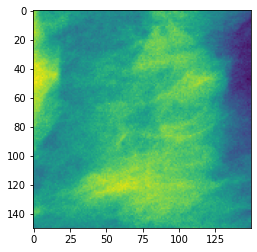

In [ ]:
plt.imshow(test_images[90])